# NFT Price Analysis

Create data analytics reports and a machine learning model that can help anticipate the floor price of NFTs. With the NFT market expanding rapidly, precise forecasts of their value have become critical for investment decisions and pricing risk assessments associated with NFT financial products.

### By Luca Ordronneau

In [1]:
import os
import ast 
import pandas as pd
import numpy as np
from math import ceil

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy.stats import linregress
from collections import Counter

from umap import UMAP
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

from kneed import KneeLocator
from yellowbrick.cluster import KElbowVisualizer

import plotly.io as pio
pio.templates.default = "seaborn"

import warnings
warnings.filterwarnings("ignore")

/Users/lucaordronneau/miniconda3/envs/general/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATAFILE = "../data/Azuki_BAYC_MAYC_Otherdeed_Moonbirds.csv"

df = pd.read_csv(DATAFILE, low_memory=False)
df = df[~df["is_multi_token_sale"]]

### NFT collections choice:
- Azuki
- BoredApeYachtClub

In [3]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Data Analysis
### 1. Analyze how the number of daily transactions for the collections has changed over time

In [4]:
df_transactions = df.groupby(["collection_name", pd.Grouper(key="timestamp", freq="D")], as_index=False).agg({"transaction_hash":"count"})
df_transactions

,collection_name,timestamp,transaction_hash
0,Azuki,2022-01-12 00:00:00+00:00,2497
1,Azuki,2022-01-13 00:00:00+00:00,1426
2,Azuki,2022-01-14 00:00:00+00:00,488
3,Azuki,2022-01-15 00:00:00+00:00,510
4,Azuki,2022-01-16 00:00:00+00:00,372
...,...,...,...
2365,Otherdeed,2023-03-19 00:00:00+00:00,368
2366,Otherdeed,2023-03-20 00:00:00+00:00,324
2367,Otherdeed,2023-03-21 00:00:00+00:00,455
2368,Otherdeed,2023-03-22 00:00:00+00:00,456


In [5]:
def create_trendline(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    ref_date = df['timestamp'].iloc[0]
    df['X'] = (df['timestamp'] - ref_date).dt.total_seconds()
    slope, intercept, r_value, p_value, std_err = linregress(df['X'], df['transaction_hash'])
    df['transaction_hash_pred'] = slope * df['X'] + intercept
    return df

In [6]:
df_transactions_azk = df_transactions[df_transactions["collection_name"] == "Azuki"]
df_transactions_ape = df_transactions[df_transactions["collection_name"] == "BoredApeYachtClub"]

df_transactions_azk_tmp = create_trendline(df_transactions_azk)
df_transactions_ape_tmp = create_trendline(df_transactions_ape)

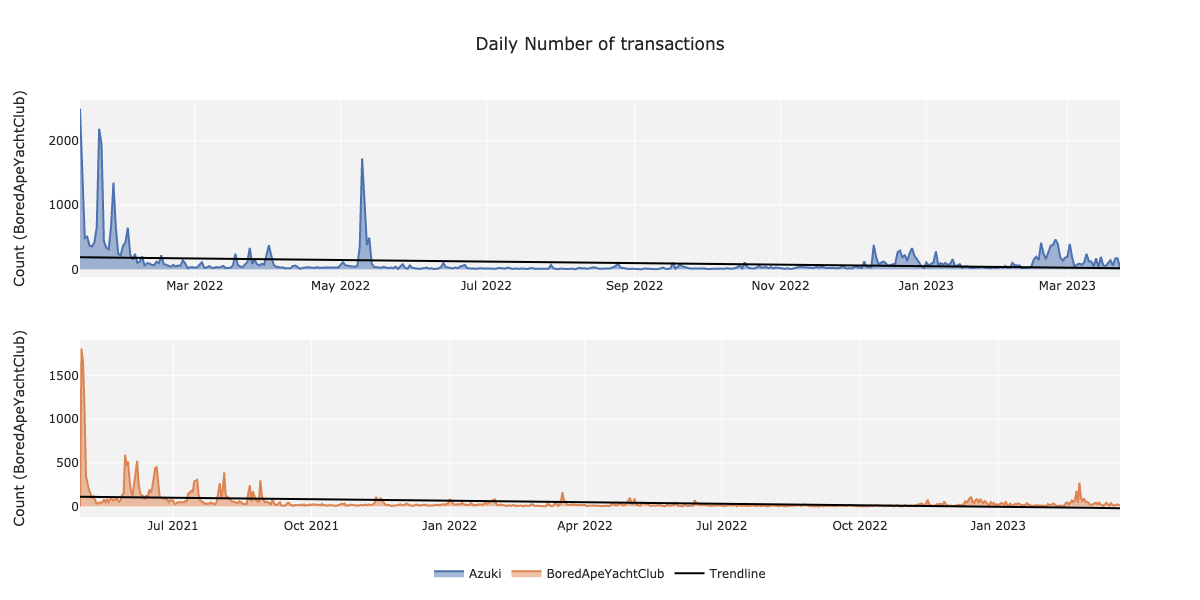

In [7]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(x=df_transactions_azk_tmp["timestamp"], y=df_transactions_azk_tmp['transaction_hash'], name="Azuki", fill='tozeroy'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_transactions_ape["timestamp"], y=df_transactions_ape['transaction_hash'], name="BoredApeYachtClub", fill='tozeroy'), row=2, col=1)

fig.add_trace(go.Scatter(x=df_transactions_ape["timestamp"], y=df_transactions_ape['transaction_hash_pred'], name="Trendline", line_color='black', legendgroup="trend"), row=2, col=1)
fig.add_trace(go.Scatter(x=df_transactions_azk_tmp["timestamp"], y=df_transactions_azk_tmp['transaction_hash_pred'], name="Trendline", line_color='black', legendgroup="trend"), row=1, col=1)

names = set()
fig.for_each_trace(lambda trace: trace.update(showlegend=False) if (trace.name in names) else names.add(trace.name))
fig.update_layout(title={'text':'Daily Number of transactions'})
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'}, legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_yaxes(title_text='Count (Azuki)')
fig.update_yaxes(title_text='Count (BoredApeYachtClub)')
fig.update_layout(width=1200, height=600)
fig.show("png")

BoredApeYatchClub stats

In [8]:
df_transactions_ape[["transaction_hash"]].describe()

,transaction_hash
count,693.000000
mean,48.004329
std,120.696120
min,1.000000
25%,11.000000
50%,19.000000
75%,42.000000
max,1806.000000


Azuki stats

In [9]:
df_transactions_azk[["transaction_hash"]].describe()

,transaction_hash
count,436.000000
mean,104.435780
std,244.047843
min,2.000000
25%,18.750000
50%,33.000000
75%,86.250000
max,2497.000000


### 2. Can you identify any clusters or groups of NFTs within the collection based on their attributes or characteristics? If so, what are the key features of these groups?

In [10]:
def get_number_of_cluster(df, collection_name):
    df = df[df["collection_name"] == collection_name]

    properties = df["flattened_properties"].unique().tolist()
    parsed_properties = [ast.literal_eval(row) for row in properties]
    flattened_properties = [" ".join([f"{k} {v}" for k, v in prop.items()]) for prop in parsed_properties]

    # Tokenize and preprocess text
    tokens = [word_tokenize(row) for row in flattened_properties]
    preprocessed_tokens = []
    for row in tokens:
        processed_row = [token.lower() for token in row if token.isalpha()]
        preprocessed_tokens.append(" ".join(processed_row))

    # Create a document-term matrix using TF-IDF
    vectorizer = TfidfVectorizer()
    dtm = vectorizer.fit_transform(preprocessed_tokens)

    print(f'Elbow Method to determine the number of clusters to be formed for {collection_name} colection:')
    elbow_m = KElbowVisualizer(KMeans(random_state=22), k=(1,13))
    elbow_m.fit(dtm.toarray())

    elbow_m.show()

    return elbow_m.elbow_value_

Elbow Method to determine the number of clusters to be formed for BoredApeYachtClub colection:


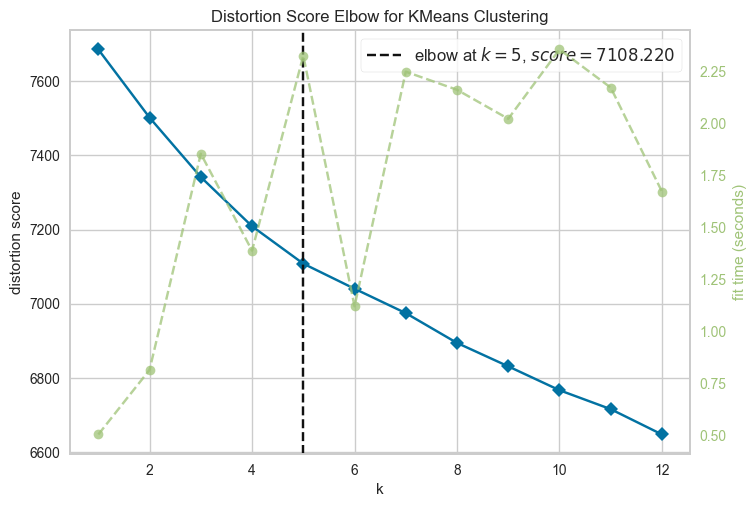

Elbow Method to determine the number of clusters to be formed for Azuki colection:


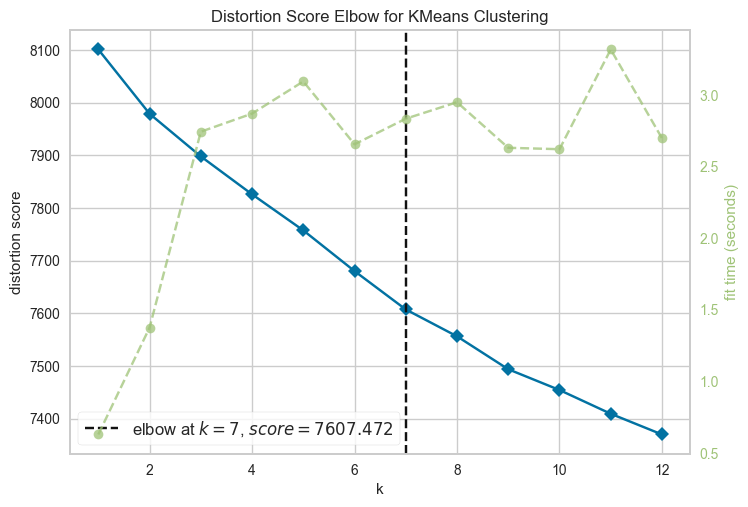

Nb Clusters BoredApeYachtClub: 5 | Nb Clusters Azuki: 7


In [11]:
n_clusters_ape = get_number_of_cluster(df, "BoredApeYachtClub")
n_clusters_azk = get_number_of_cluster(df, "Azuki")

print(f"Nb Clusters BoredApeYachtClub: {n_clusters_ape} | Nb Clusters Azuki: {n_clusters_azk}")

In [12]:
def nft_group_attributes_cluster(df, collection_name, n_clusters=7):
    df = df[df["collection_name"] == collection_name]

    properties = df["flattened_properties"].unique().tolist()
    parsed_properties = [ast.literal_eval(row) for row in properties]
    flattened_properties = [" ".join([f"{k} {v}" for k, v in prop.items()]) for prop in parsed_properties]

    # Tokenize and preprocess text
    tokens = [word_tokenize(row) for row in flattened_properties]
    preprocessed_tokens = []
    for row in tokens:
        processed_row = [token.lower() for token in row if token.isalpha()]
        preprocessed_tokens.append(" ".join(processed_row))

    # Create a document-term matrix using TF-IDF
    vectorizer = TfidfVectorizer()
    dtm = vectorizer.fit_transform(preprocessed_tokens)

    # umap_model = UMAP(n_components=2, random_state=42)
    # umap_embeddings = umap_model.fit_transform(dtm)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(dtm)

    df_result = pd.DataFrame(parsed_properties)
    attributes = list(df_result.columns)

    df_result['raw_properties'] = properties
    df_result['cluster_label'] = labels
    
    df = df.merge(df_result[["raw_properties", "cluster_label"]], left_on="flattened_properties", right_on="raw_properties")

    return df, df_result, attributes

In [13]:
df_azk, df_azk_attributes, attributes_azk = nft_group_attributes_cluster(df, "Azuki", 7)
df_ape, df_ape_attributes, attributes_ape = nft_group_attributes_cluster(df, "BoredApeYachtClub", 5)

In [14]:
def get_cluster_attributes(df, attributes):
    cluster_attributes = {}

    labels = df['cluster_label'].tolist()

    for cluster_id in set(labels):
        cluster_rows = df[df['cluster_label'] == cluster_id]
        attribute_counts = Counter()
        for _, row in cluster_rows.iterrows():
            for k, v in row.items():
                if k in attributes and not pd.isnull(v):
                    attribute_counts[f"{k}: {v}"] += 1
        cluster_attributes[cluster_id] = attribute_counts

    common_attributes = set(cluster_attributes[0].keys())
    for cluster_id in set(labels):
        common_attributes.intersection_update(cluster_attributes[cluster_id].keys())

    top_n = 5  # Adjust this value to show more or fewer key features per cluster
    for cluster_id, attribute_counts in cluster_attributes.items():
        print(f"Cluster {cluster_id}:")

        # Remove common attributes from each cluster's attribute counts
        unique_attribute_counts = attribute_counts.copy()
        for common_attribute in common_attributes:
            del unique_attribute_counts[common_attribute]

        # Print most frequent unique attributes
        print("Most frequent unique attributes:")
        for attribute, count in unique_attribute_counts.most_common(top_n):
            print(f"  {attribute}: {count}")
        print()

In [15]:
get_cluster_attributes(df_azk_attributes, attributes_azk)

Cluster 0:
Most frequent unique attributes:
  Face: Red Stripes Face Paint: 264
  Face: Red Fang Face Paint: 243
  Eyes: Daydreaming: 27
  Mouth: Frown: 26
  Eyes: Indifferent: 26

Cluster 1:
Most frequent unique attributes:
  Hair: Maroon Bun: 115
  Hair: Maroon Half Bun: 96
  Hair: Blue Half Bun: 86
  Hair: Brown Half Bun: 85
  Hair: Purple Bun: 84

Cluster 2:
Most frequent unique attributes:
  Hair: Blonde Swept Back: 83
  Hair: Orange Swept Back: 80
  Hair: Powder Blue Swept Back: 77
  Hair: Indigo Swept Back: 74
  Hair: Silver Swept Back: 72

Cluster 3:
Most frequent unique attributes:
  Mouth: Lipstick: 209
  Eyes: Ruby: 202
  Eyes: Amethyst: 195
  Eyes: Calm: 193
  Eyes: Daydreaming: 192

Cluster 4:
Most frequent unique attributes:
  Hair: Brown Spiky: 116
  Hair: Blonde Short Spiky: 109
  Hair: Blue Spiky: 107
  Hair: Maroon Short Spiky: 105
  Hair: Green Spiky: 103

Cluster 5:
Most frequent unique attributes:
  Clothing: Turquoise Kimono: 177
  Clothing: Lavender Kimono with B

In [16]:
get_cluster_attributes(df_ape_attributes, attributes_ape)

Cluster 0:
Most frequent unique attributes:
  Hat: Bayc Flipped Brim: 195
  Hat: Bayc Hat Black: 159
  Clothes: Bayc T Black: 143
  Background: Purple: 115
  Background: Orange: 110

Cluster 1:
Most frequent unique attributes:
  Earring: Silver Hoop: 528
  Earring: Silver Stud: 498
  Background: Purple: 321
  Background: Aquamarine: 286
  Earring: Gold Hoop: 270

Cluster 2:
Most frequent unique attributes:
  Background: New Punk Blue: 1095
  Earring: Silver Stud: 97
  Earring: Silver Hoop: 90
  Earring: Gold Stud: 61
  Earring: Gold Hoop: 46

Cluster 3:
Most frequent unique attributes:
  Background: Orange: 762
  Background: Aquamarine: 733
  Background: Purple: 713
  Hat: Ww2 Pilot Helm: 76
  Clothes: Service: 68

Cluster 4:
Most frequent unique attributes:
  Background: Army Green: 1085
  Earring: Silver Hoop: 103
  Earring: Silver Stud: 83
  Earring: Gold Hoop: 53
  Earring: Gold Stud: 43



### 3. Can you identify any correlations between the characteristics of the NFTs within the collection and their prices? If so, what are the most important factors influencing the prices?

In [17]:
def merge_collection_df_attributes(df, df_attributes, attributes):
    return df.merge(df_attributes[["raw_properties"] + attributes], left_on="flattened_properties", right_on="raw_properties")

In [18]:
df_azk_all = merge_collection_df_attributes(df_azk, df_azk_attributes, attributes_azk)
df_ape_all = merge_collection_df_attributes(df_ape, df_ape_attributes, attributes_ape)

In [19]:
df_azk_all.head()

,__indexer_id,__confirmed,__block_number,block_number,log_index,transaction_hash,timestamp,exchange_name,contract_version,aggregator_name,...,Type,Mouth,Clothing,Background,Offhand,Face,Neck,Headgear,Special,Ear
0,blur-nft-sales,False,16890064,16890064,351,0x463a893f33905fb1d0c998bfdf45490878e82f2fa8d6...,2023-03-23 11:52:35+00:00,blur,v1,NaN,...,Human,Chuckle,Suikan,Off White C,NaN,NaN,NaN,NaN,NaN,NaN
1,blur-nft-sales,True,16889124,16889124,642,0x1981eb0557d4412c2b76431825dbca09431ad02fa909...,2023-03-23 08:42:23+00:00,blur,v1,NaN,...,Human,Chuckle,Suikan,Off White C,NaN,NaN,NaN,NaN,NaN,NaN
2,blur-nft-sales,True,16887128,16887128,224,0xc60fc1bd0e2c36d5b4bd3161c95f0975c211eff6fa01...,2023-03-23 01:56:59+00:00,blur,v1,NaN,...,Human,Chuckle,Suikan,Off White C,NaN,NaN,NaN,NaN,NaN,NaN
3,blur-nft-sales,True,16884219,16884219,242,0x4a4daebb05db249ee37f8f975405bb59f523c60ce3d5...,2023-03-22 16:08:35+00:00,blur,v1,NaN,...,Human,Chuckle,Suikan,Off White C,NaN,NaN,NaN,NaN,NaN,NaN
4,blur-nft-sales,True,16882118,16882118,381,0xd7625c91ee25220bcf2f3c34248cd6e6ec47f101d835...,2023-03-22 09:03:11+00:00,blur,v1,NaN,...,Human,Chuckle,Suikan,Off White C,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
def get_influencing_price_factors(df, attributes):
    dummy_df = pd.get_dummies(df[attributes].applymap(lambda x: f"{x}_1" if x == 1 else x))
    dummy_df["usd_price"] = df["usd_price"]

    correlations = dummy_df.corr(method='pearson')['usd_price']
    sorted_correlations = correlations.reindex(correlations.abs().sort_values(ascending=False).index)
    sorted_correlations_plot = correlations.reindex(correlations.sort_values(ascending=False).index)

    top_n = 10
    print(f"Top {top_n} factors influencing NFT prices:")
    influencing_factors = []
    for idx, corr in sorted_correlations[:top_n].items():
        if idx == 'usd_price':
            continue
        
        col = idx.split("_")[0]
        val = idx.split("_")[1]

        mean_price = df[df[col] == val]["usd_price"].mean()
        print(f"  {idx}: {corr:.3f} | Mean price: {mean_price:.3f}$")
        influencing_factors.append((idx, corr, mean_price))
    
    return sorted_correlations_plot

In [26]:
def plot_influencing_price_factors(df, sorted_correlations, top_n=10):
    factors = []
    values = []
    mean_prices = []

    for idx, corr in sorted_correlations[:top_n+1].items():
        if idx == 'usd_price':
            continue

        col = idx.split("_")[0]
        val = idx.split("_")[1]

        mean_price = df[df[col] == val]["usd_price"].mean()
        factors.append(idx)
        values.append(corr)
        mean_prices.append(mean_price)

    fig = make_subplots(rows=1, cols=2, shared_xaxes=True)
    fig.add_trace(go.Bar(x=factors, y=values, name='Correlation Coefficient', marker_color='rgb(25, 74, 159)'), row=1, col=1)
    fig.add_trace(go.Bar(name='Mean Price (USD)', x=factors, y=mean_prices, marker_color='rgb(159, 25, 74)'), row=1, col=2)

    fig.update_layout(
        title='Top 10 Factors Influencing NFT Prices BoredApeYatchClub',
        xaxis_title='Factor',
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
    )

    fig.show("png")

In [22]:
influencing_factors_azk = get_influencing_price_factors(df_azk_all, attributes_azk)

Top 10 factors influencing NFT prices:
  Type_Spirit: 0.347 | Mean price: 146833.243$
  Hair_Spirit Goddess: 0.167 | Mean price: 155418.217$
  Hair_Spirit Long: 0.159 | Mean price: 175813.781$
  Hair_Spirit Fluffy: 0.157 | Mean price: 167793.871$
  Hair_Spirit Ponytail: 0.146 | Mean price: 154729.586$
  Type_Human: -0.131 | Mean price: 23957.666$
  Neck_Golden Headphones: 0.117 | Mean price: 100195.036$
  Hair_Spirit Bob: 0.117 | Mean price: 132753.833$
  Hair_Spirit Spiky: 0.094 | Mean price: 99113.885$


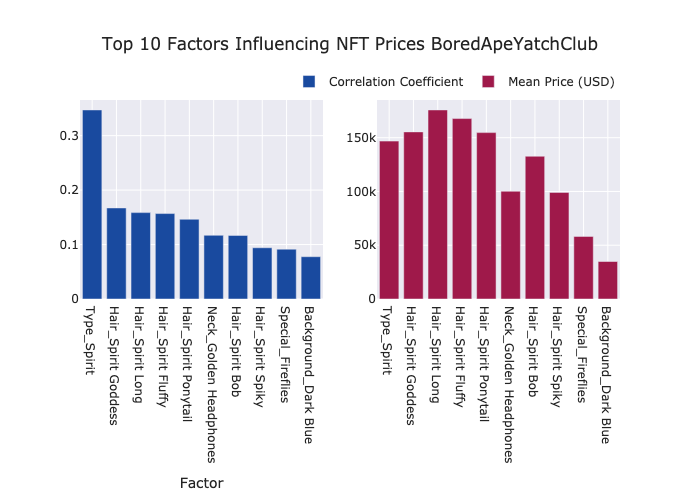

In [27]:
plot_influencing_price_factors(df_azk_all, influencing_factors_azk)

In [24]:
influencing_factors_ape =get_influencing_price_factors(df_ape_all, attributes_ape)

Top 10 factors influencing NFT prices:
  Fur_Solid Gold: 0.116 | Mean price: 400467.093$
  Fur_Trippy: 0.072 | Mean price: 224778.330$
  Eyes_Laser Eyes: 0.059 | Mean price: 188824.684$
  Eyes_Blue Beams: 0.044 | Mean price: 194606.009$
  Mouth_Bored Unshaven Dagger: 0.041 | Mean price: 223964.388$
  Hat_King's Crown: 0.040 | Mean price: 152582.772$
  Clothes_Black Suit: 0.039 | Mean price: 186936.768$
  Mouth_Bored Unshaven Pizza: 0.032 | Mean price: 206996.406$
  Clothes_Kings Robe: 0.026 | Mean price: 121373.799$


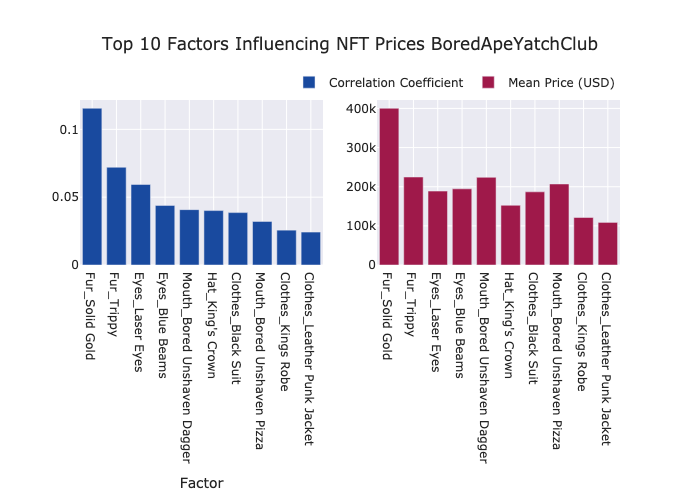

In [28]:
plot_influencing_price_factors(df_ape_all, influencing_factors_ape)

### 4. Determine the correlation between the number of transactions in a collection and its floor price.
Weekly

In [29]:
def get_corr_tx_floor_price(df, collection_name):
    df = df[df["collection_name"] == collection_name]
    df_transactions = df.groupby([pd.Grouper(key="timestamp", freq="W")], as_index=False).agg({"transaction_hash":"count", "usd_price":"min"})
    correlation = df_transactions["transaction_hash"].corr(df_transactions["usd_price"], method="pearson")
    print(f"Weekly Correlation between the number of transactions and the floor price for {collection_name} collection: {correlation:.3f}")

In [30]:
get_corr_tx_floor_price(df, "Azuki")

Weekly Correlation between the number of transactions and the floor price for Azuki collection: -0.256


In [31]:
get_corr_tx_floor_price(df, "BoredApeYachtClub")

Weekly Correlation between the number of transactions and the floor price for BoredApeYachtClub collection: -0.281


### 5. Determine the correlation between the number of transactions in a collection and the price of ETH.
If Bear market maybe less interest

In [32]:
def get_corr_tx_eth_price(df, collection_name):
    df = df[df["collection_name"] == collection_name]
    df_transactions = df.groupby([pd.Grouper(key="timestamp", freq="W")], as_index=False).agg({"transaction_hash":"count", "usd_price":"mean", "eth_price":"mean"})
    df_transactions["eth_market"] = df_transactions["usd_price"] / df_transactions["eth_price"]
    correlation = df_transactions["transaction_hash"].corr(df_transactions["eth_market"], method="pearson")
    print(f"Weekly Correlation between the number of transactions and ETH price for {collection_name} collection: {correlation:.3f}")

    return df_transactions

In [33]:
df_transactions_azk_eth_price = get_corr_tx_eth_price(df, "Azuki")

Weekly Correlation between the number of transactions and ETH price for Azuki collection: 0.375


In [34]:
df_transactions_ape_eth_price = get_corr_tx_eth_price(df, "BoredApeYachtClub")

Weekly Correlation between the number of transactions and ETH price for BoredApeYachtClub collection: 0.113


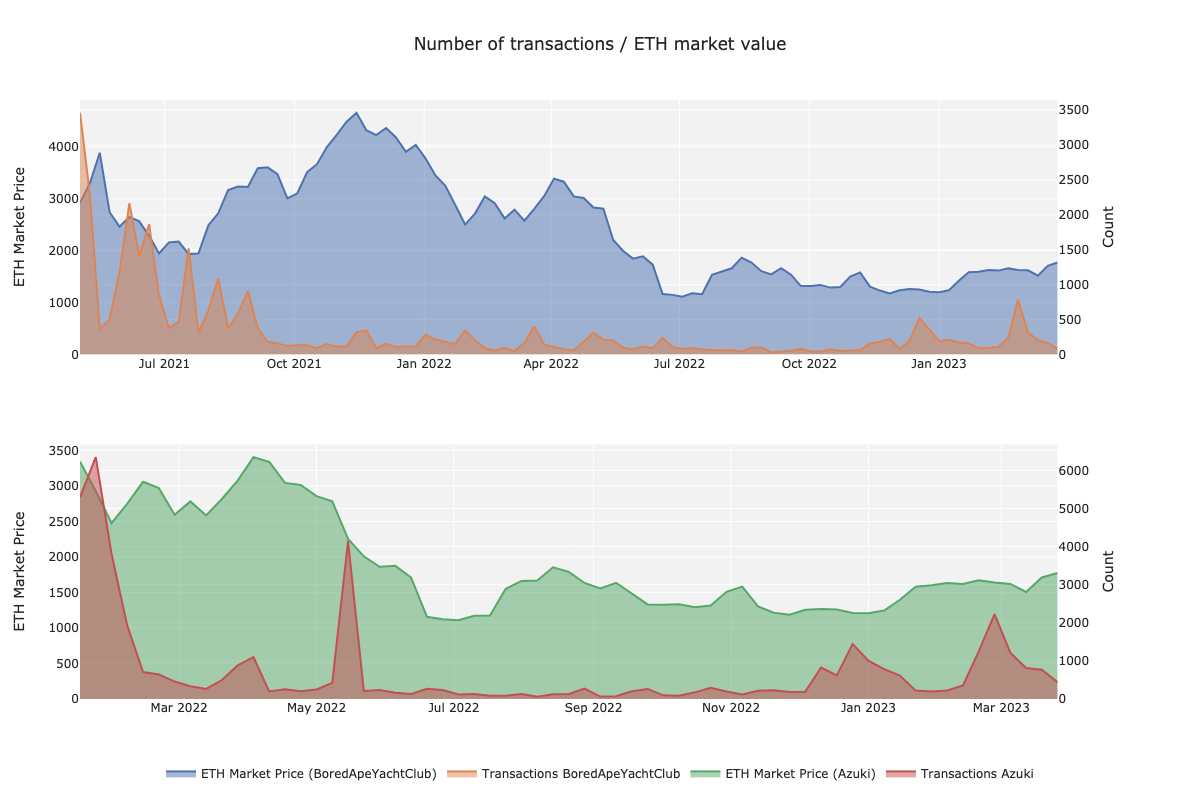

In [35]:
fig = make_subplots(rows=2, cols=1, specs=[[{"secondary_y": True}], [{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_transactions_ape_eth_price["timestamp"], y=df_transactions_ape_eth_price['eth_market'], name="ETH Market Price (BoredApeYachtClub)", fill='tozeroy'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_transactions_ape_eth_price["timestamp"], y=df_transactions_ape_eth_price['transaction_hash'], name="Transactions BoredApeYachtClub", fill='tozeroy'), row=1, col=1, secondary_y=True)

fig.add_trace(go.Scatter(x=df_transactions_azk_eth_price["timestamp"], y=df_transactions_azk_eth_price['eth_market'], name="ETH Market Price (Azuki)", fill='tozeroy'), row=2, col=1)
fig.add_trace(go.Scatter(x=df_transactions_azk_eth_price["timestamp"], y=df_transactions_azk_eth_price['transaction_hash'], name="Transactions Azuki", fill='tozeroy'), row=2, col=1, secondary_y=True)


fig.update_layout(title={'text':'Number of transactions / ETH market value'})
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'}, legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_yaxes(title_text='ETH Market Price', secondary_y=False)
fig.update_yaxes(title_text='Count', secondary_y=True)
fig.update_layout(width=1200, height=800)
fig.show("png")

# Prediction Model
9605 to analyse

### Features

In [36]:
def calculate_nft_rarity_score(properties, attribute_rarity_scores):
    rarity_score = 0
    for attribute, value in properties.items():
        key = f"{attribute}:{value}"
        rarity_score += attribute_rarity_scores.get(key, 0)
    return rarity_score

def week_of_month(dt):
    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

def get_time_indicators(df):
    df['hour'] = df['timestamp'].dt.hour
    df['day_week'] = df['timestamp'].dt.dayofweek
    df['day'] = df['timestamp'].dt.day - 1
    df['week'] = df['timestamp'].apply(week_of_month) - 1
    df['month'] = df['timestamp'].dt.month
    return df

def encode_time_indicators(data, col, max_val):
    data[f'feature_{col}_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[f'feature_{col}_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

def populate_time_indicators(df):
    df = encode_time_indicators(df, 'hour', 23)
    df = encode_time_indicators(df, "day_week", 6)
    df = encode_time_indicators(df, 'day', 30)
    df = encode_time_indicators(df, 'week', 5)
    df = encode_time_indicators(df, 'month', 12)
    return df

In [37]:
def get_features(df, attributes):
    df = df.sort_values('timestamp')
    df_transactions_floor_price = df.groupby(["token_id", pd.Grouper(key="timestamp", freq="D")], as_index=False).agg({"transaction_hash":"count", "usd_price":"min"}).sort_values('timestamp')
    df_transactions_floor_price = df_transactions_floor_price.rename(columns={"transaction_hash":"feature_transaction_count_token", "usd_price":"target_floor_price"})

    df_transactions_max = df.groupby([pd.Grouper(key="timestamp", freq="D")], as_index=False).agg({"transaction_hash":"count", "usd_price":"min"}).rename(columns={"transaction_hash":"feature_transaction_count", "usd_price":"feature_usd_price_max"}).sort_values('timestamp')
    df_transactions_mean = df.groupby([pd.Grouper(key="timestamp", freq="D")], as_index=False).agg({"usd_price":"mean"}).rename(columns={"usd_price":"feature_usd_price_mean"}).sort_values('timestamp')
    df_transactions_volume = df.groupby([pd.Grouper(key="timestamp", freq="D")], as_index=False).agg({"usd_price":"sum"}).rename(columns={"usd_price":"feature_usd_volume"}).sort_values('timestamp')
    df_transactions_general_floor_price = df.groupby([pd.Grouper(key="timestamp", freq="D")], as_index=False).agg({"usd_price":"min"}).rename(columns={"usd_price":"feature_general_floor_price"}).sort_values('timestamp')

    df = pd.merge_asof(df, df_transactions_floor_price, on="timestamp", by='token_id', direction="nearest")
    df = pd.merge_asof(df, df_transactions_max, on="timestamp", direction="nearest")
    df = pd.merge_asof(df, df_transactions_mean, on="timestamp", direction="nearest")
    df = pd.merge_asof(df, df_transactions_volume, on="timestamp", direction="nearest")
    df = pd.merge_asof(df, df_transactions_general_floor_price, on="timestamp", direction="nearest")

    # # Add time indicators 
    df = get_time_indicators(df)
    df = populate_time_indicators(df)

    # Get ETH market price
    df["feature_eth_market"] = df["usd_price"] / df["eth_price"]

    # Compute rarity score
    df["parsed_properties"] = df["flattened_properties"].apply(lambda x: ast.literal_eval(x))

    attribute_counts = {}
    for idx, row in df.iterrows():
        for attribute, value in row["parsed_properties"].items():
            key = f"{attribute}:{value}"
            if key not in attribute_counts:
                attribute_counts[key] = 0
            attribute_counts[key] += 1

    attribute_rarity_scores = {key: 1 / count for key, count in attribute_counts.items()}
    df["feature_rarity_score"] = df["parsed_properties"].apply(lambda x: calculate_nft_rarity_score(x, attribute_rarity_scores))

    # # Get influencing factor corr by NFT
    # dummy_df = pd.get_dummies(df[attributes].applymap(lambda x: f"{x}_1" if x == 1 else x))
    # dummy_df["usd_price"] = df["usd_price"]
    # df_correlations = pd.DataFrame(dummy_df.corr(method='pearson')['usd_price'].reset_index(name='corr'))

    # corr_attributes_price = []
    # for idx, row in df.iterrows():
    #     nft_corr_value = 0
    #     for attribute, value in row["parsed_properties"].items():
    #         nft_corr_value += df_correlations[df_correlations["index"] == f"{attribute}_{value}"]["corr"].values[0]
    #     corr_attributes_price.append(nft_corr_value)

    # df["feature_corr_attributes_price"] = corr_attributes_price

    dummy_df_exchange = pd.get_dummies(df[['exchange_name']])
    dummy_df_exchange["usd_price"] = df["usd_price"]
    df_correlations_exchange = pd.DataFrame(dummy_df_exchange.corr(method='pearson')['usd_price'].reset_index(name='corr'))
    corr_exchange_price = []
    for idx, row in df.iterrows():
        exchange_corr_value = df_correlations_exchange[df_correlations_exchange["index"].str.contains(row["exchange_name"])]["corr"].values[0]
        corr_exchange_price.append(exchange_corr_value)

    df["feature_corr_exchange_price"] = corr_exchange_price
    
    return df

In [38]:
df_model = get_features(df_azk_all, attributes_azk)

In [39]:
features_cols = df_model.columns[df_model.columns.str.startswith('feature')]
df_model[features_cols.tolist()]

,feature_transaction_count_token,feature_transaction_count,feature_usd_price_max,feature_usd_price_mean,feature_usd_volume,feature_general_floor_price,feature_hour_sin,feature_hour_cos,feature_day_week_sin,feature_day_week_cos,feature_day_sin,feature_day_cos,feature_week_sin,feature_week_cos,feature_month_sin,feature_month_cos,feature_eth_market,feature_rarity_score,feature_corr_exchange_price
0,1,1426,594.54,7568.366914,10792491.22,594.54,-0.979084,0.203456,8.660254e-01,-0.5,0.743145,-0.669131,0.587785,-0.809017,0.5,8.660254e-01,3377.390000,0.011204,0.026599
1,1,1426,594.54,7568.366914,10792491.22,594.54,-0.979084,0.203456,8.660254e-01,-0.5,0.743145,-0.669131,0.587785,-0.809017,0.5,8.660254e-01,3377.391960,0.010071,0.026599
2,1,1426,594.54,7568.366914,10792491.22,594.54,-0.979084,0.203456,8.660254e-01,-0.5,0.743145,-0.669131,0.587785,-0.809017,0.5,8.660254e-01,3378.970000,0.005815,0.026599
3,1,1426,594.54,7568.366914,10792491.22,594.54,-0.979084,0.203456,8.660254e-01,-0.5,0.743145,-0.669131,0.587785,-0.809017,0.5,8.660254e-01,3378.967568,0.018818,0.026599
4,2,1426,594.54,7568.366914,10792491.22,594.54,-0.979084,0.203456,8.660254e-01,-0.5,0.743145,-0.669131,0.587785,-0.809017,0.5,8.660254e-01,3378.969543,0.014197,0.026599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45529,1,29,22378.68,24744.610690,717593.71,22378.68,0.136167,-0.990686,1.224647e-16,-1.0,-0.994522,-0.104528,-0.587785,-0.809017,1.0,6.123234e-17,1753.059724,0.005418,-0.099645
45530,2,29,22378.68,24744.610690,717593.71,22378.68,0.136167,-0.990686,1.224647e-16,-1.0,-0.994522,-0.104528,-0.587785,-0.809017,1.0,6.123234e-17,1753.059922,0.007629,-0.099645
45531,2,29,22378.68,24744.610690,717593.71,22378.68,0.136167,-0.990686,1.224647e-16,-1.0,-0.994522,-0.104528,-0.587785,-0.809017,1.0,6.123234e-17,1757.079755,0.009806,-0.099645
45532,2,29,22378.68,24744.610690,717593.71,22378.68,0.136167,-0.990686,1.224647e-16,-1.0,-0.994522,-0.104528,-0.587785,-0.809017,1.0,6.123234e-17,1757.619632,0.004099,-0.099645


In [ ]:
import wandb

wb_secret_value = "YOUR_API_KEY"

!wandb login $wb_secret_value

In [40]:
sweep_config = {
    "method": "bayes",
    "metric": {
      "name": "rmse",
      "goal": "minimize"   
    },
    "parameters": {
        "subsample":{
            "min": 0.5,
            "max": 1.0
        },
        "colsample_bytree": {
            "min": 0.1,
            "max": 0.4
        },
        "max_depth": {
            "min": 4,
            "max": 10
        },
        "learning_rate": {
            "min": 0.002,
            "max": 0.03
        },
        "n_estimators" : {
            "min": 400,
            "max": 3000
        },
        "reg_lambda" : {
            "min": 0.0,
            "max": 2.0
        },
        "reg_alpha" : {
            "min": 0.0,
            "max": 1.0
        }
    }
}

In [41]:
import gc 
import torch

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

def sweep_xgb_model():
    
    with wandb.init():
        config = wandb.config
        
        gc.collect()
        torch.cuda.empty_cache()

        features = df_model.columns[df_model.columns.str.startswith('feature_')]
        target   = df_model.columns[df_model.columns.str.startswith('target_')][0]
        
        model = XGBRegressor(colsample_bytree=config.colsample_bytree, max_depth=config.max_depth,
                            learning_rate=config.learning_rate, reg_lambda=config.reg_lambda, reg_alpha=config.reg_alpha,
                            n_estimators=config.n_estimators, subsample=config.subsample,
                            # sampling_method='gradient_based', tree_method='gpu_hist', predictor='gpu_predictor',
                            objective="reg:squarederror", eval_metric="rmse")
        
        nmse_result = []
        rmse_result = []
        
        # Initialize the KFold cross-validator using the 'FOLD' column
        n_folds = df_model['cluster_label'].nunique()
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

        # Perform cross-validation
        mse_scores = []

        for fold, (train_index, val_index) in enumerate(kf.split(df)):
            print(f'--- Fold: {fold} ---')
            print(f'Fold {fold+1}: Train indices {len(train_index)}, Test indices {len(val_index)}')

            # Split the data into train and validation sets based on the 'FOLD' column
            X_train, X_val = df_model.loc[train_index, features], df_model.loc[val_index, features]
            y_train, y_val = df_model.loc[train_index, target], df_model.loc[val_index, target]

            # Fit the model on the training data
            model.fit(X_train, y_train)

            # Make predictions on the validation data
            y_pred = model.predict(X_val)

            # Calculate the mean squared error and append it to the list of scores
            mse = mean_squared_error(y_val, y_pred)
            mse_scores.append(mse)
            
        rmse_cv_mean = np.mean(mse_scores)
        print(f'--- rmse mean: {rmse_cv_mean} ---')
        
        wandb.log({"rmse":rmse_cv_mean})
        
        del model

        gc.collect()
        torch.cuda.empty_cache()

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="nft-pa")
wandb.agent(sweep_id, function=sweep_xgb_model, count=3)

In [42]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor

# Extract the features and target
features = df_model.columns[df_model.columns.str.startswith('feature_')]
target   = df_model.columns[df_model.columns.str.startswith('target_')][0]

params = {
        "colsample_bytree":0.23,
        "max_depth":8,
        "learning_rate":0.025,
        "n_estimators":2360,
        "subsample":0.93,
        "reg_lambda":0.39, # L2 Regularization
        "reg_alpha":0.09,
        # "sampling_method":'gradient_based', "tree_method":'gpu_hist', "predictor":'gpu_predictor',
        "objective":"reg:squarederror",
        "eval_metric":"rmse"
}

# Create the XGBoost model
model = XGBRegressor(**params)

X_train = df_model[df_model["token_id"] != 9605][features]
y_train = df_model[df_model["token_id"] != 9605][target]

X_test = df_model[df_model["token_id"] == 9605][features]
y_test = df_model[df_model["token_id"] == 9605][target]


# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the validation data
y_pred = model.predict(X_test)

In [62]:
last_row = df_model[df_model["token_id"] == 9605].tail(1)
print("On", last_row["timestamp"].values[0] ,", Market price of Azuki #9606 is", y_test.tail(1).values[0], "$ and the prediction of the floor price of the rarest NFT is:", y_pred[-1], "$")

On 2022-03-30T04:16:40.000000000 , Market price of Azuki #9606 is 1424801.52 $ and the prediction of the floor price of the rarest NFT is: 250780.81 $
